# transverse diffusion calculation

- slice PSF along Z
- extract fit
- fit linear trend to output, will give transverse diffusion

In [1]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
                            # NOTE if you can't import IC stuff, its because of the
                            # above line
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import os
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from IC.invisible_cities.reco.psf_functions    import create_psf
from IC.invisible_cities.reco.psf_functions    import hdst_psf_processing
from IC.invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from IC.invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import IC.invisible_cities.core.core_functions as     coref
import IC.invisible_cities.io  .dst_io         as     dstio

from IC.invisible_cities.database              import load_db
#from IC.invisible_cities.io      .kdst_io      import psf_writer
# he's dead jim, make psf_writer yourself

import functions as func

%load_ext autoreload
%autoreload 2

In [2]:
# Define a Gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))


In [3]:
psf_path  = 'psfs/'
psf_path2 = '../Tl_studies/psf_study/psfs/'
psf_MC_4bar = dstio.load_dst(psf_path + 'n100_mc_4bar.psf', 'PSF', 'PSFs')
psf_data_R15616 = dstio.load_dst('/home/e78368jw/Documents/NEXT_CODE/next_misc/eutricide/psfs/' + '040925_full_25us.psf', 'PSF', 'PSFs')



In [4]:
display(psf_MC_4bar)
print('MC-4bar - Z spacing')
print(psf_MC_4bar.z.unique())
print('========================\n')
print('R15616 - Z spacing')
print(psf_data_R15616.z.unique())
print('========================\n')

,xr,yr,zr,x,y,z,factor,nevt
0,-99.5,-99.5,0.0,0.0,0.0,70.0,0.000000,2891
1,-99.5,-99.5,0.0,0.0,0.0,170.0,0.000004,2889
2,-99.5,-99.5,0.0,0.0,0.0,270.0,0.000045,2961
3,-99.5,-99.5,0.0,0.0,0.0,370.0,0.000028,2908
4,-99.5,-99.5,0.0,0.0,0.0,470.0,0.000029,2927
...,...,...,...,...,...,...,...,...
479995,99.5,99.5,0.0,0.0,0.0,770.0,0.000034,3180
479996,99.5,99.5,0.0,0.0,0.0,870.0,0.000069,3179
479997,99.5,99.5,0.0,0.0,0.0,970.0,0.000178,3111
479998,99.5,99.5,0.0,0.0,0.0,1070.0,0.000248,3137


MC-4bar - Z spacing
[  70.  170.  270.  370.  470.  570.  670.  770.  870.  970. 1070. 1170.]

R15616 - Z spacing
[  12.5   37.5   62.5   87.5  112.5  137.5  162.5  187.5  212.5  237.5
  262.5  287.5  312.5  337.5  362.5  387.5  412.5  437.5  462.5  487.5
  512.5  537.5  562.5  587.5  612.5  637.5  662.5  687.5  712.5  737.5
  762.5  787.5  812.5  837.5  862.5  887.5  912.5  937.5  962.5  987.5
 1012.5 1037.5 1062.5 1087.5 1112.5 1137.5 1162.5 1187.5]



In [5]:
# select a particular x value to slice across, I'd say near zero.
print(psf_MC_4bar.xr.unique())
print(psf_data_R15616.xr.unique())

[-99.5 -98.5 -97.5 -96.5 -95.5 -94.5 -93.5 -92.5 -91.5 -90.5 -89.5 -88.5
 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5 -77.5 -76.5
 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5
 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5
 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5
 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5
 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5
 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5
  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5
   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5
  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5
  32.5  33.5  34.5  35.5  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5
  44.5  45.5  46.5  47.5  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5
  56.5  57.5  58.5  59.5  60.5  61.5  62.5  63.5  6

In [6]:
MC4bar_rr = func.rr_process(psf_MC_4bar)
R15616_rr = func.rr_process(psf_data_R15616)

Fitted parameters: a=0.2118989029843219, x0=0.47289251225122336, sigma=13.050926659691678


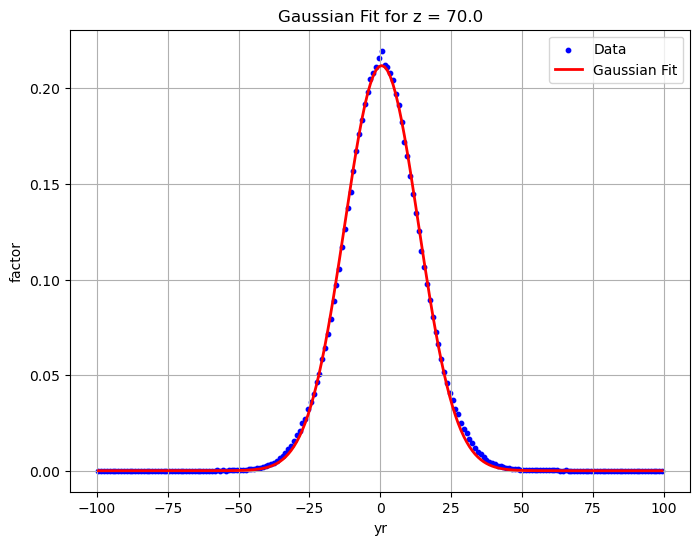

Fitted parameters: a=0.1548188391359581, x0=1.269837908303703, sigma=15.368612272233277


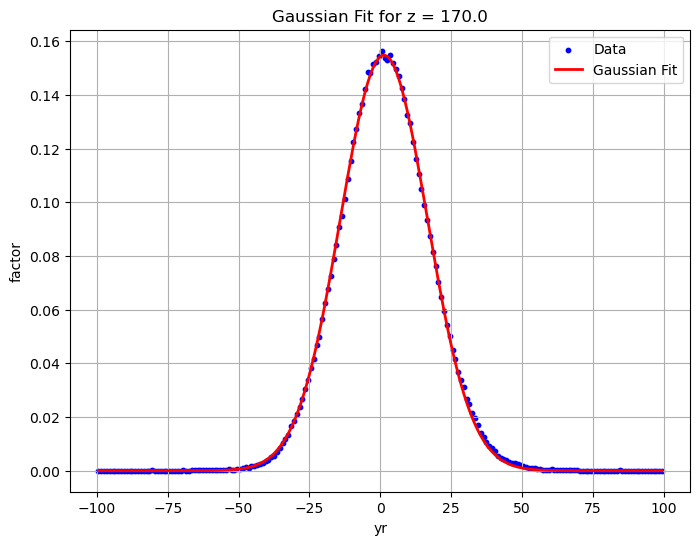

Fitted parameters: a=0.11827390099149998, x0=2.0168281140494844, sigma=17.47323859304601


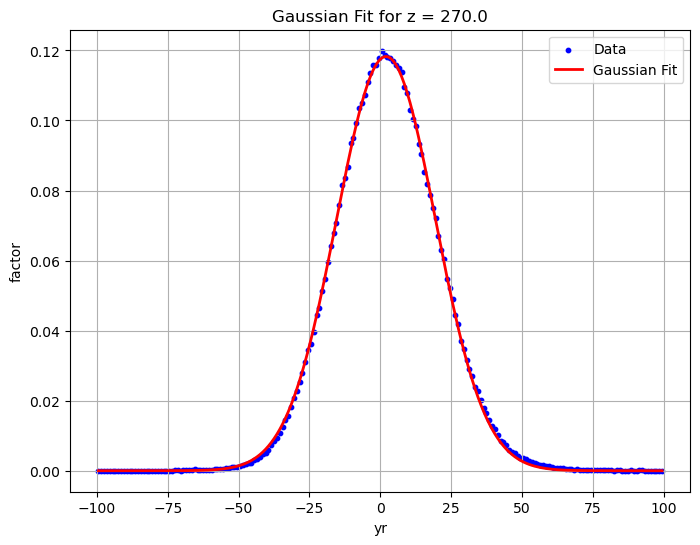

Fitted parameters: a=0.09191975548046552, x0=2.7996254218459358, sigma=19.638213571588384


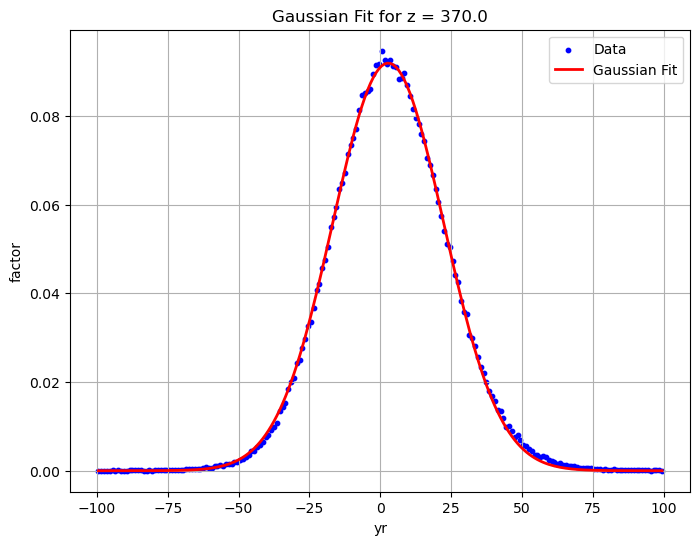

Fitted parameters: a=0.07286179700775872, x0=3.609284787019549, sigma=21.82630830061368


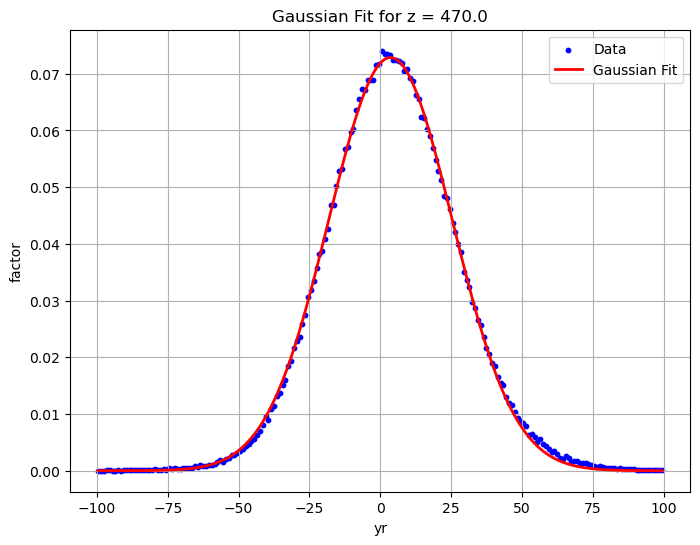

Fitted parameters: a=0.05795436608676002, x0=4.3714925298701415, sigma=24.262206029423133


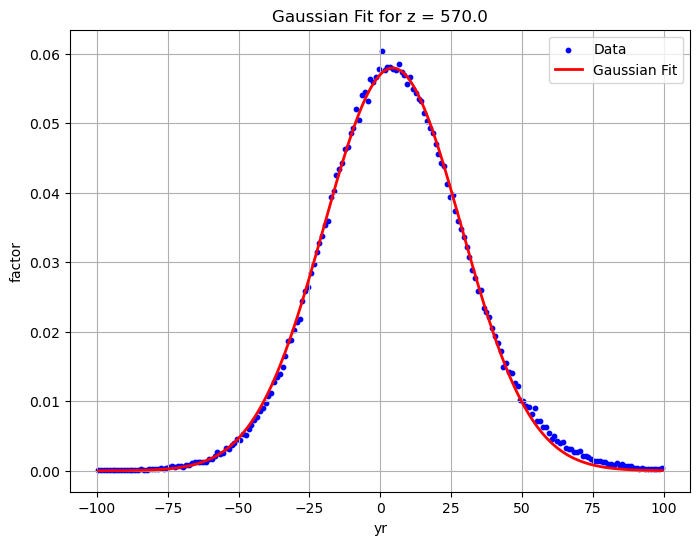

Fitted parameters: a=0.04668832812816835, x0=5.27993436890078, sigma=26.766642836286554


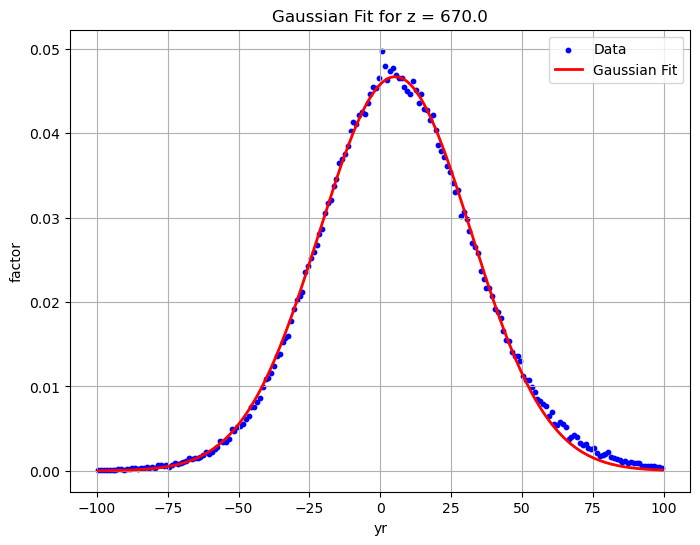

Fitted parameters: a=0.03757285762150305, x0=5.946779285073848, sigma=29.67501675632703


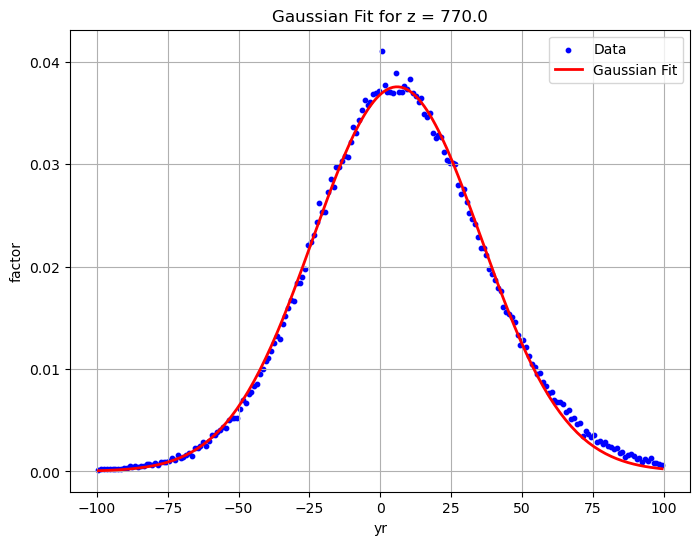

Fitted parameters: a=0.03025014896515165, x0=6.747388432885031, sigma=32.828129549935504


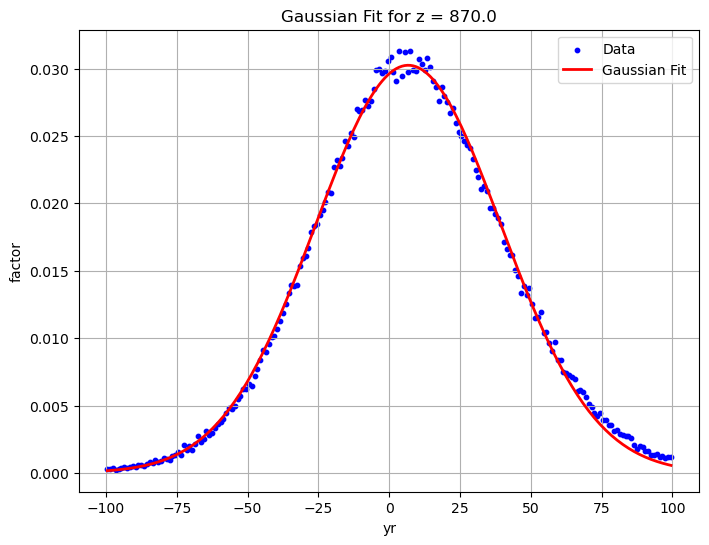

Fitted parameters: a=0.02471257434520189, x0=7.497341124122973, sigma=35.95296853189304


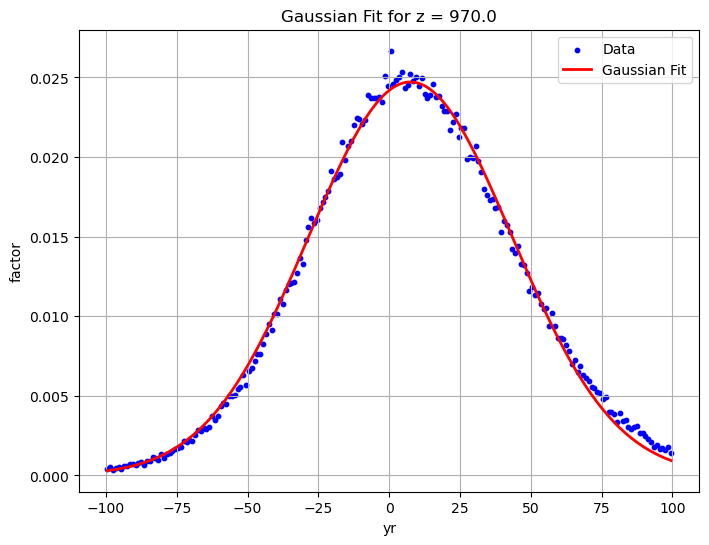

Fitted parameters: a=0.02030341791152544, x0=8.410036414190229, sigma=39.60053197928023


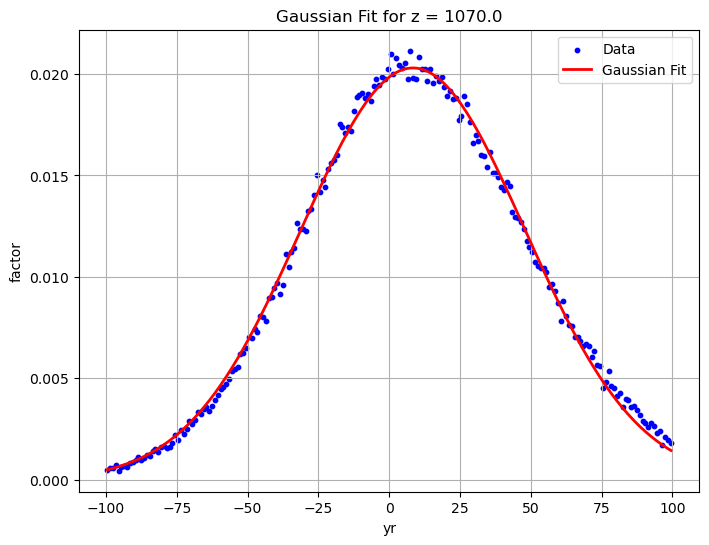

Fitted parameters: a=0.01732709318011463, x0=8.731046460094266, sigma=42.751370597808474


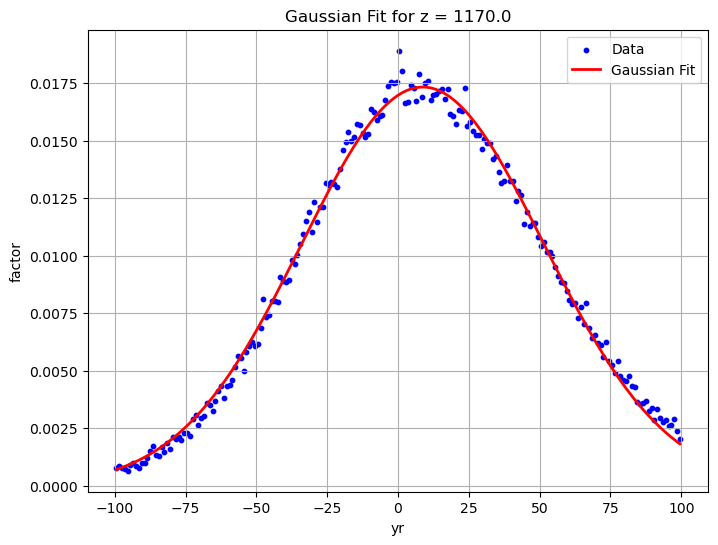

In [13]:
from scipy.optimize import curve_fit

sigma_list = {}

for z_val in psf_MC_4bar.z.unique():
    
    ## whole R
    #data = func.z_specific_rr(psf_MC_4bar, z_val)
    #y_data = np.concatenate([np.flip((data.factor.values)), (data.factor.values)])
    #x_data = np.concatenate([np.flip((-data.rr.values)), (data.rr.values)])
    #label = 'rr'
    
    # specific z value
    data = psf_MC_4bar[psf_MC_4bar.xr == 0.5]
    data = data[data.z == z_val]
    # symmetric around deltaR = 0
    y_data = data.factor.values
    x_data = data.yr.values
    label = 'yr'



    # Fit the Gaussian curve
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])

    # Extract the fitted parameters
    a, x0, sigma = popt
    print(f"Fitted parameters: a={a}, x0={x0}, sigma={sigma}")
    # Plot the data and the Gaussian fit
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, label='Data', color='blue', s=10)
    plt.plot(x_data, gaussian(x_data, *popt), label='Gaussian Fit', color='red', linewidth=2)
    plt.xlabel(f'{label}')
    plt.ylabel('factor')
    plt.title(f'Gaussian Fit for z = {z_val}')
    plt.legend()
    plt.grid()
    plt.show()

    sigma_list[z_val] = sigma

    

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_34123/2020785141.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sqrt{Z}$ Value')


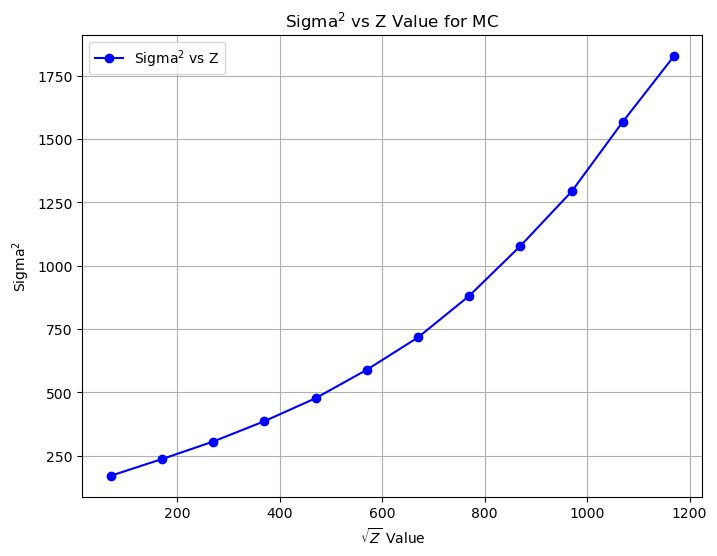

In [16]:
# Extract keys and values from sigma_list
z_values = (list(sigma_list.keys()))
sigma_values = np.square(list(sigma_list.values()))


# Plot the data
plt.figure(figsize=(8, 6))

plt.plot(z_values, sigma_values, marker='o', linestyle='-', color='b', label='Sigma$^2$ vs Z')
plt.xlabel('$\sqrt{Z}$ Value')
plt.ylabel('Sigma$^2$')
plt.title('Sigma$^2$ vs Z Value for MC')
plt.grid()
plt.legend()
plt.show()

Linear fit coefficients: Slope = 1.4661068408932079, Intercept = -115.17120387372591


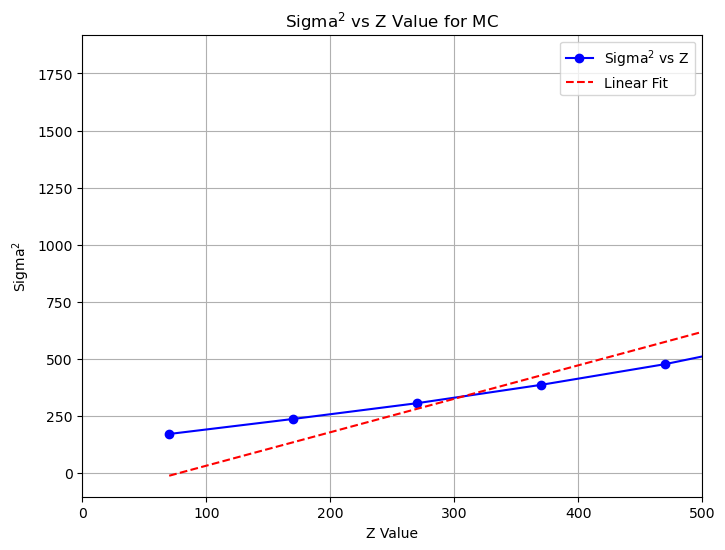

In [21]:
# Extract keys and values from sigma_list
z_values = (list(sigma_list.keys()))
sigma_values = np.square(list(sigma_list.values()))

# Fit a linear trend to the data
coefficients = np.polyfit(z_values, sigma_values, 1)
linear_fit = np.poly1d(coefficients)

# Print the coefficients
print(f"Linear fit coefficients: Slope = {coefficients[0]}, Intercept = {coefficients[1]}")

# Plot the data
plt.figure(figsize=(8, 6))

plt.plot(z_values, sigma_values, marker='o', linestyle='-', color='b', label='Sigma$^2$ vs Z')
plt.plot(z_values, linear_fit(z_values), linestyle='--', color='r', label='Linear Fit')
plt.xlabel('Z Value')
plt.ylabel('Sigma$^2$')
plt.title('Sigma$^2$ vs Z Value for MC')
plt.grid()
plt.legend()
plt.xlim([0,500])
plt.show()

Fitted parameters: a=0.13967709413938004, x0=-1.0389798513385913e-10, sigma=-14.710715068716988


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


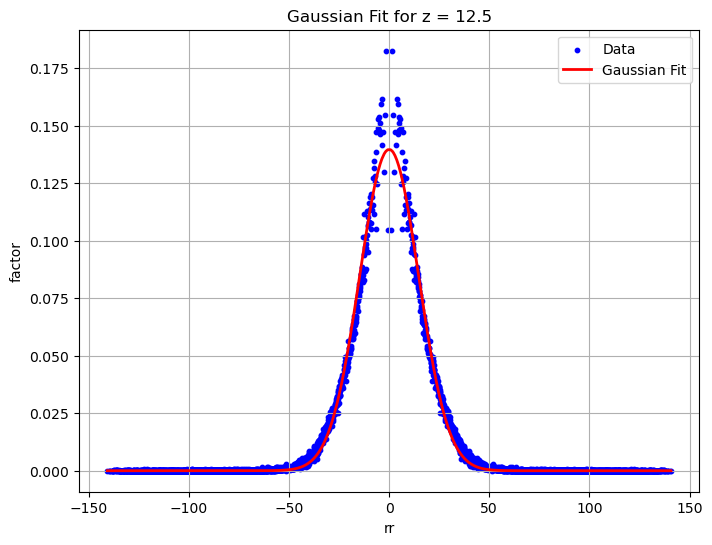

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.27120536035340825, x0=-1.595741448823562e-09, sigma=10.995010028767114


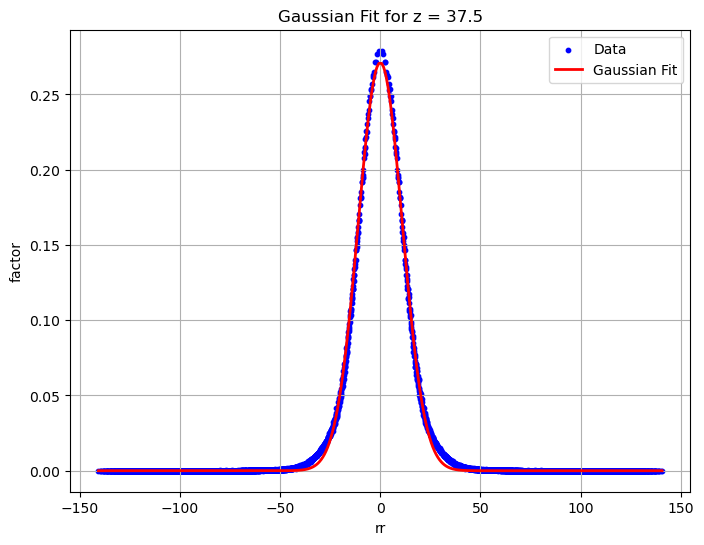

Fitted parameters: a=0.2634298656164875, x0=-2.050342674812203e-06, sigma=11.285132283824089


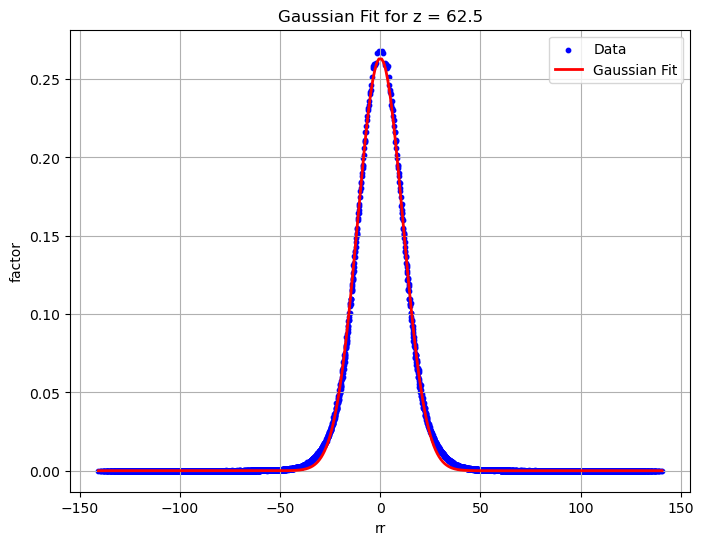

Fitted parameters: a=0.25063041407492376, x0=-5.067123559403633e-10, sigma=11.632742098111088


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


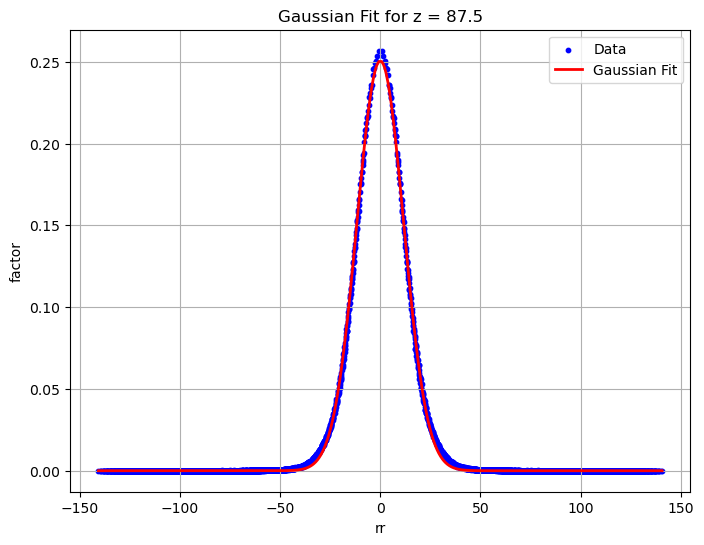

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.23913166188351098, x0=-4.803214294130335e-10, sigma=11.954184931141516


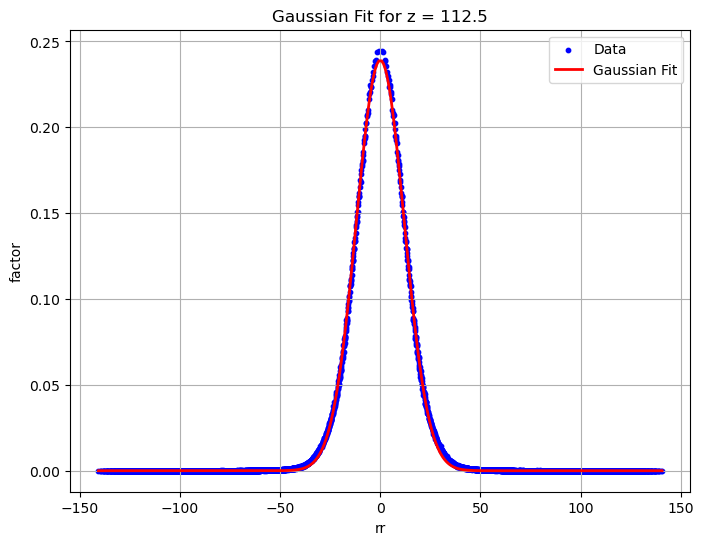

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.22860248455700208, x0=-9.032150237366128e-11, sigma=12.261509896045315


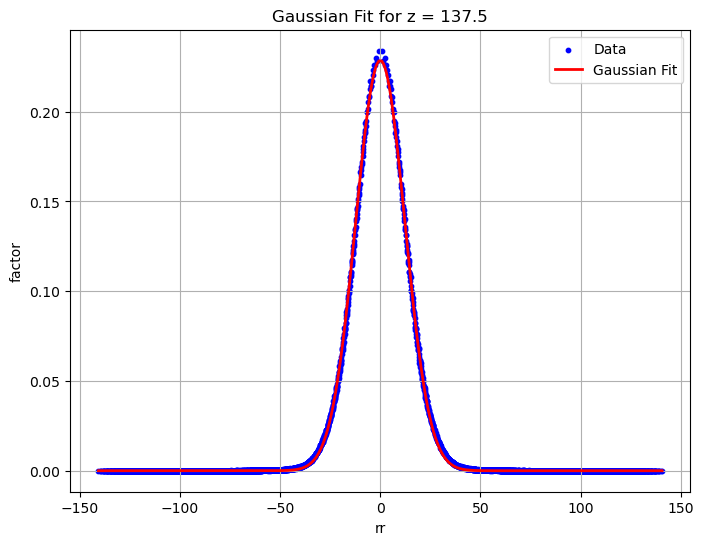

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.21939559634618105, x0=-8.593772325592474e-11, sigma=12.537281457460324


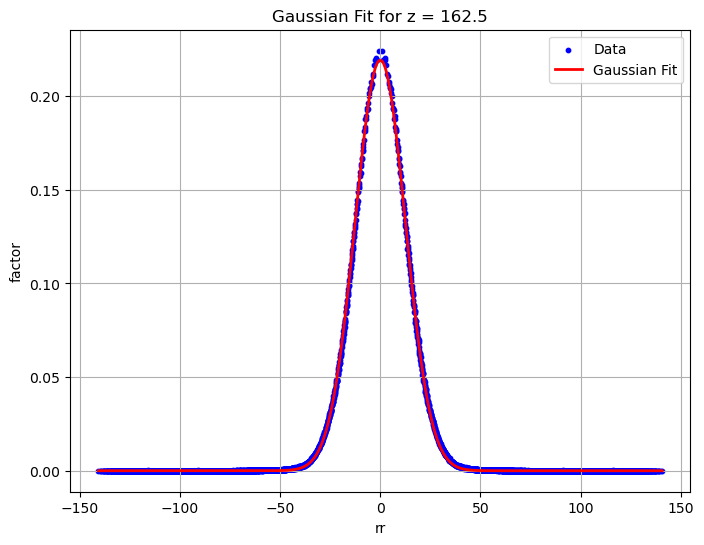

Fitted parameters: a=0.2115245099178533, x0=-7.145968796607421e-10, sigma=12.790102987925083


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


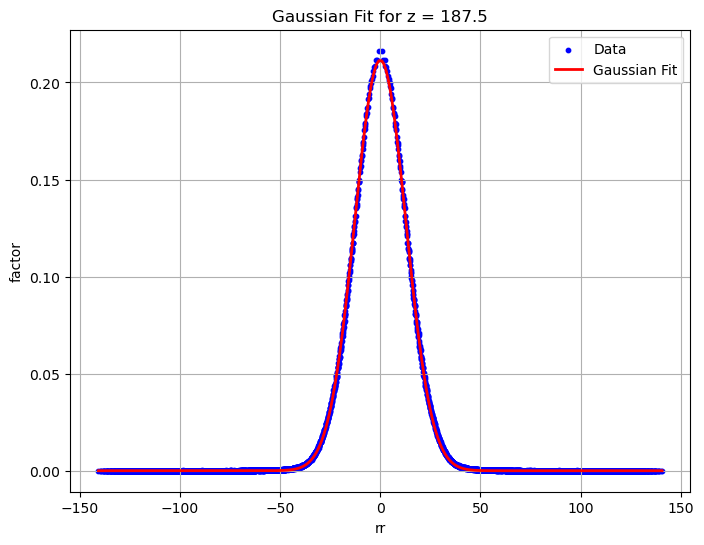

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.20416759445211474, x0=-3.6554423493065875e-10, sigma=13.032979421911673


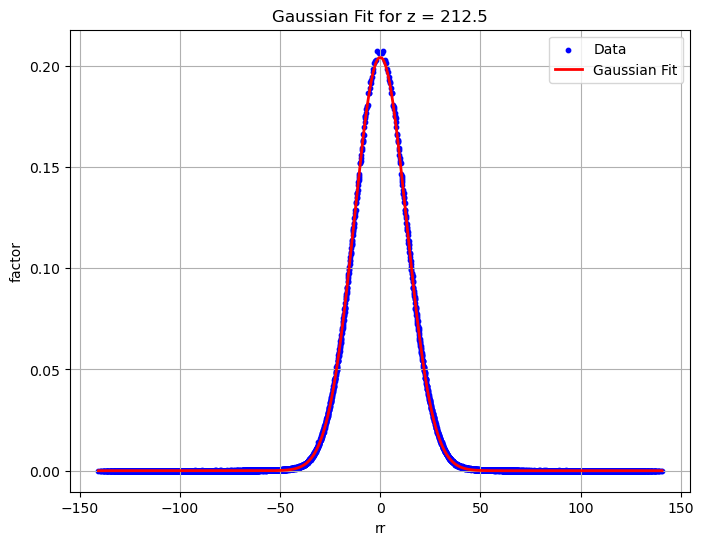

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.19752643016266463, x0=-3.7301642575845883e-10, sigma=13.250630437916195


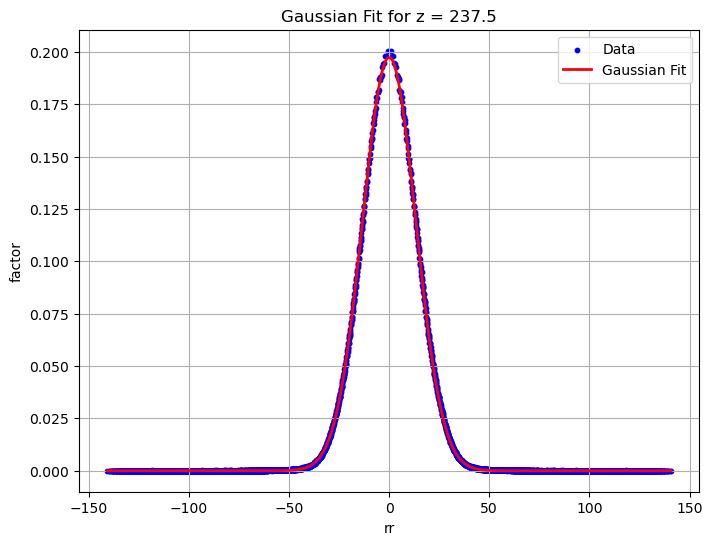

Fitted parameters: a=0.19168259389230724, x0=-3.1204104382333243e-06, sigma=13.462321722102438


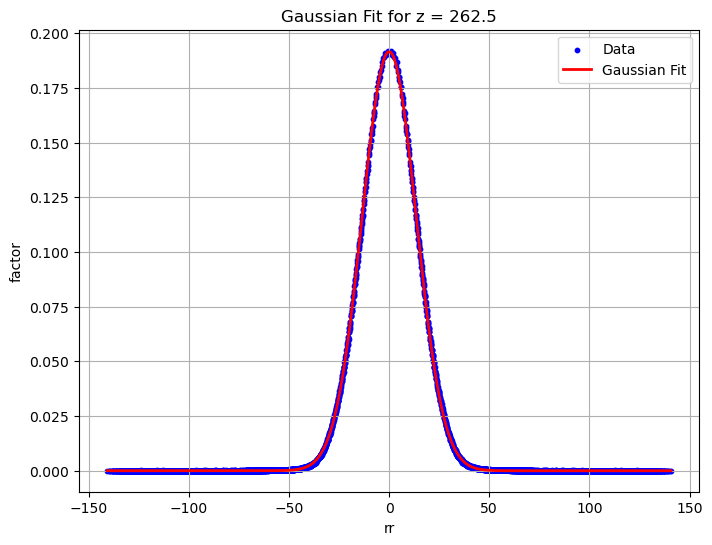

Fitted parameters: a=0.1865004022765494, x0=-3.5263062869216894e-10, sigma=13.645571768961616


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


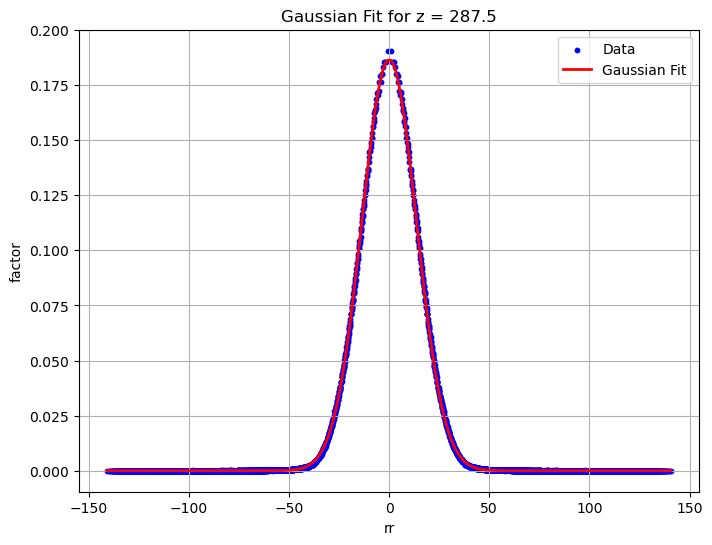

Fitted parameters: a=0.1818028943576691, x0=-6.058829227250393e-10, sigma=13.812025633322822


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


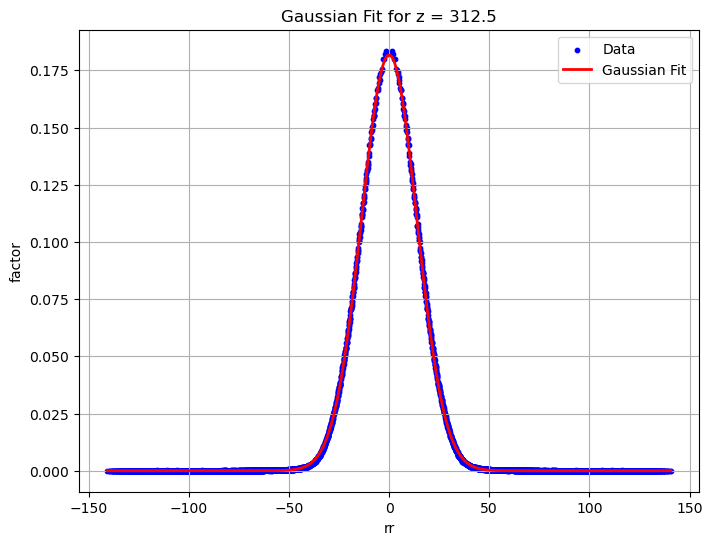

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.17733919714912713, x0=-5.1439457120984324e-11, sigma=13.985225980546522


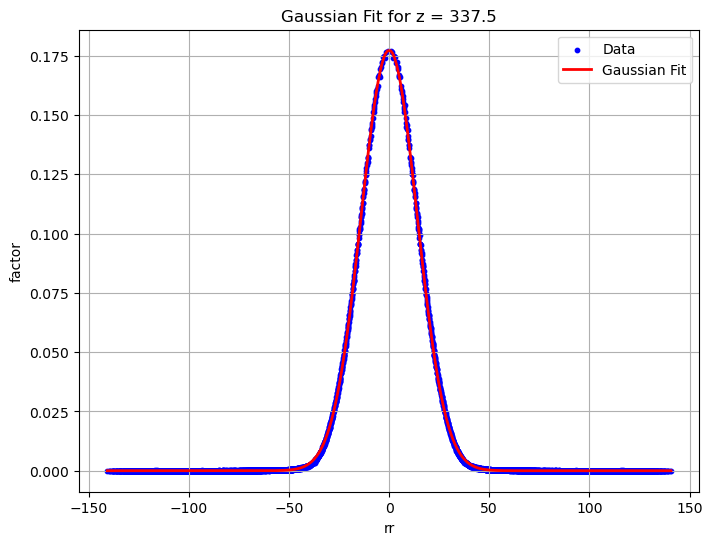

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.17315118153976694, x0=-3.154629754269579e-10, sigma=14.142210852848775


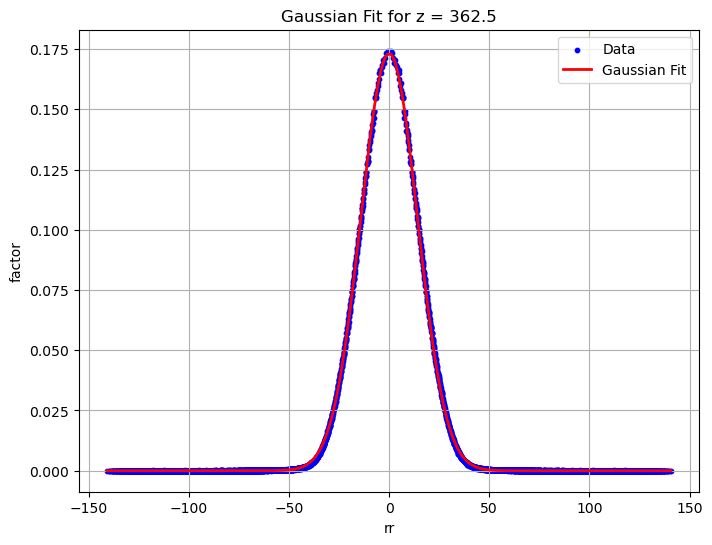

Fitted parameters: a=0.16953573732741029, x0=-3.129541013286101e-10, sigma=14.287657636197931


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


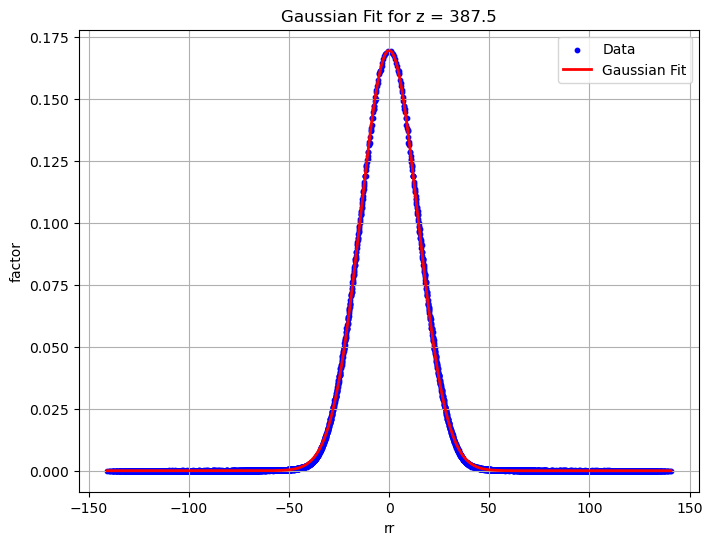

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.16627260715365966, x0=-5.6736376490758585e-11, sigma=14.409664038062933


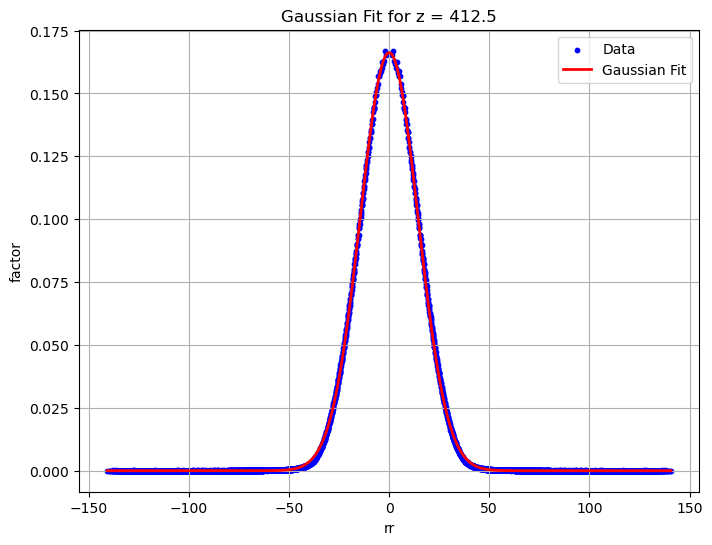

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.1630306803501602, x0=-3.00043096436482e-10, sigma=14.545613903078033


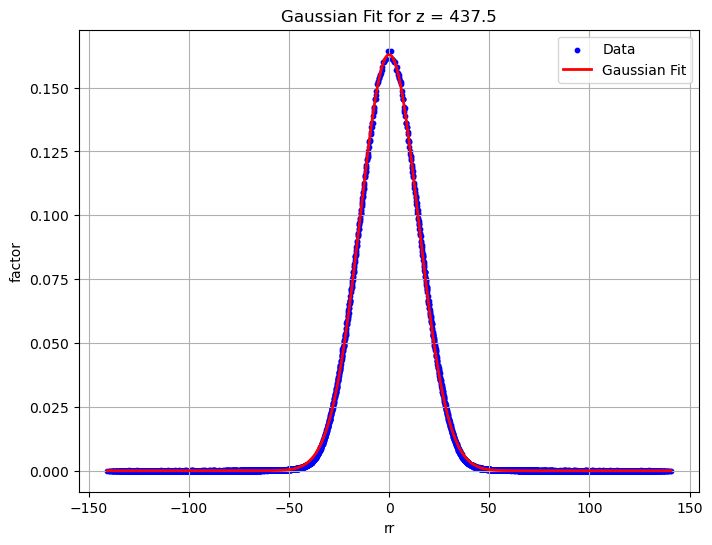

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.16008115190128366, x0=-2.999423041462724e-10, sigma=14.654708699864317


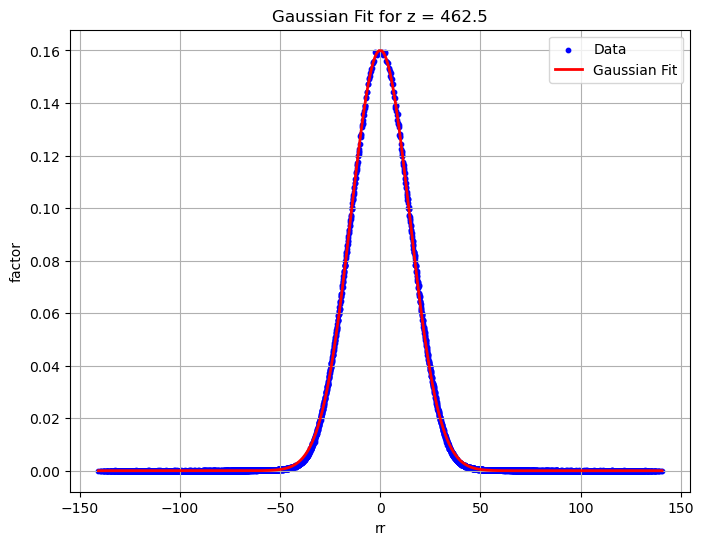

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.1573647791722326, x0=-5.226381346038012e-10, sigma=14.767611038974252


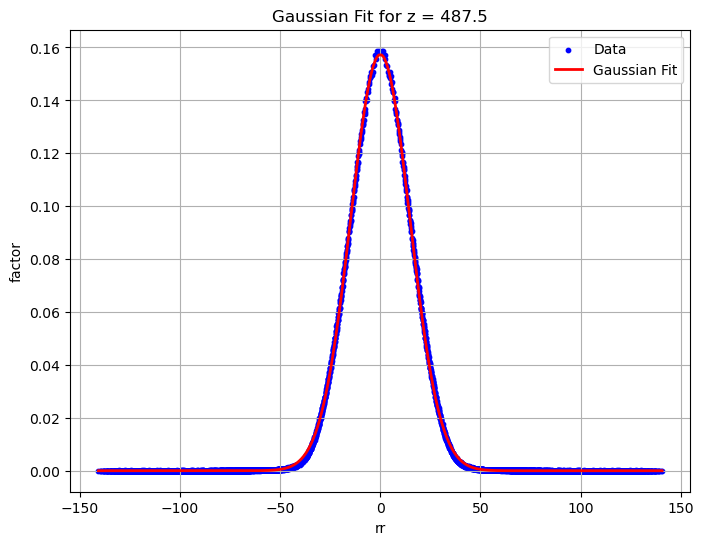

Fitted parameters: a=0.155101669569945, x0=-5.1402433927929964e-11, sigma=14.853853557009373


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


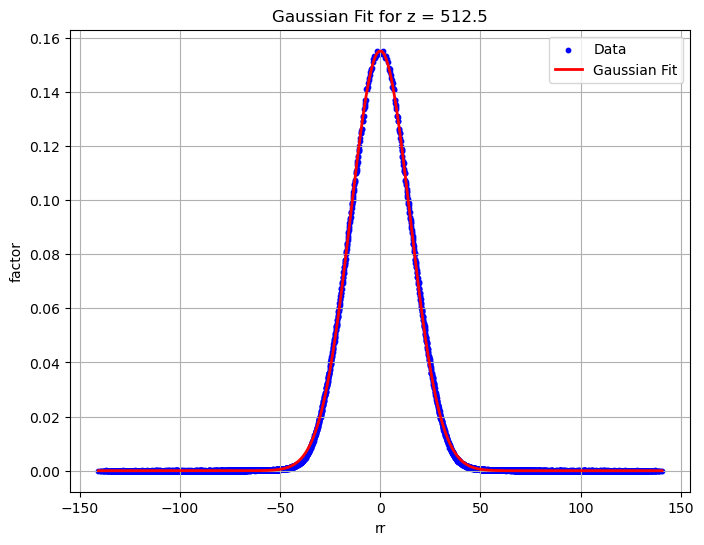

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.15263102251542449, x0=-2.860024021268311e-10, sigma=14.961103814783332


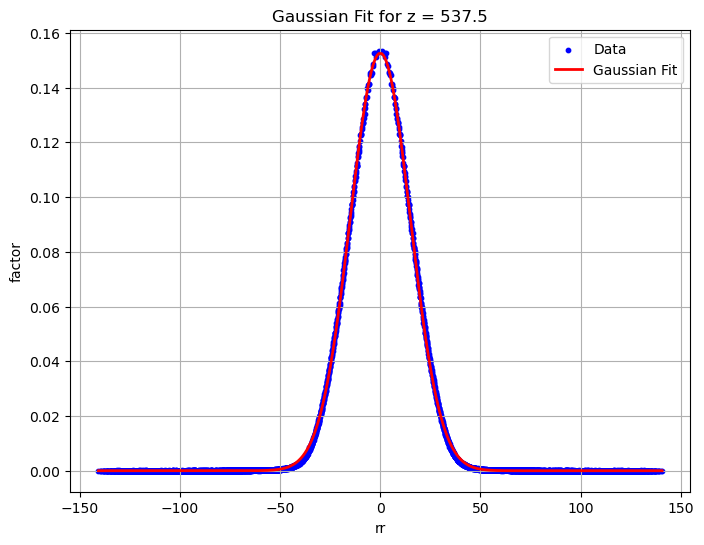

Fitted parameters: a=0.15075206999802604, x0=-2.827539081075059e-10, sigma=15.027796234238426


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


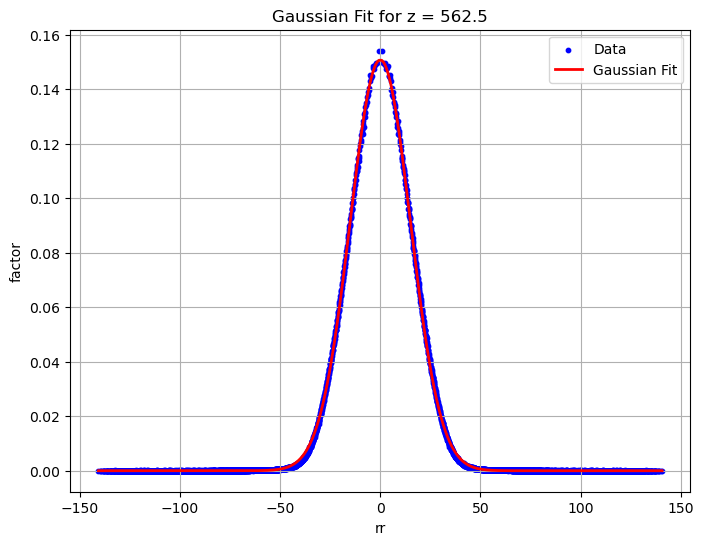

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.14853297035486357, x0=-2.676237228580101e-10, sigma=15.122272547713635


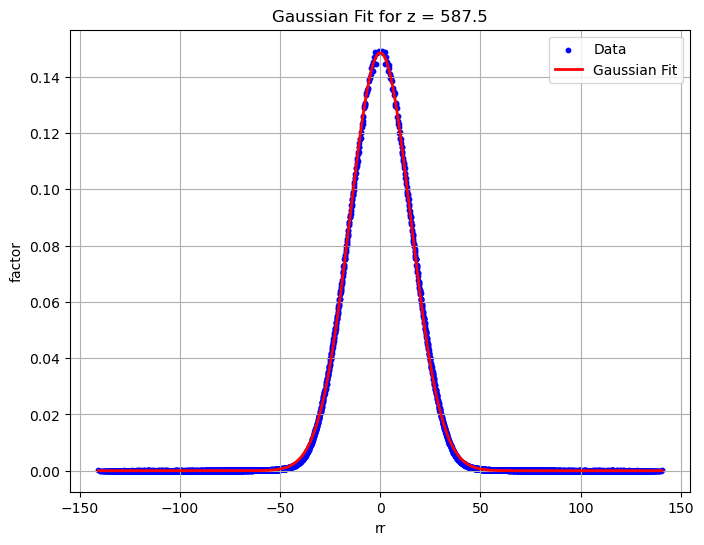

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.14686310617569082, x0=-5.1398733309788093e-11, sigma=15.187735354773235


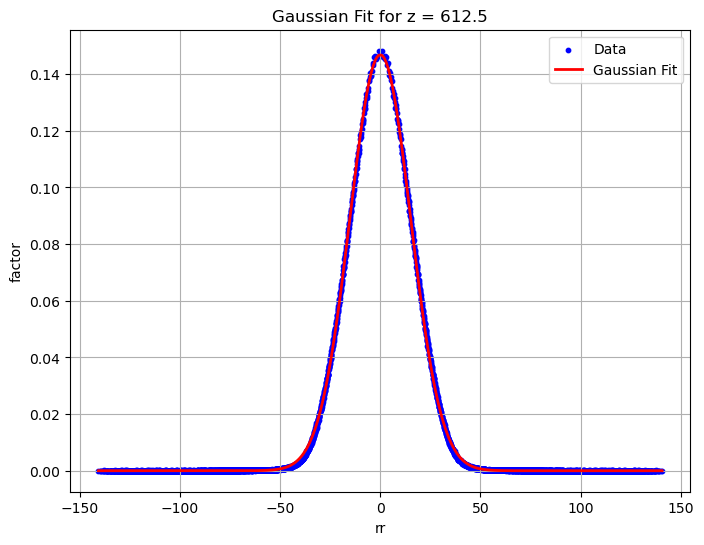

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.1447289590068256, x0=-4.6695589215643663e-11, sigma=15.274556780197035


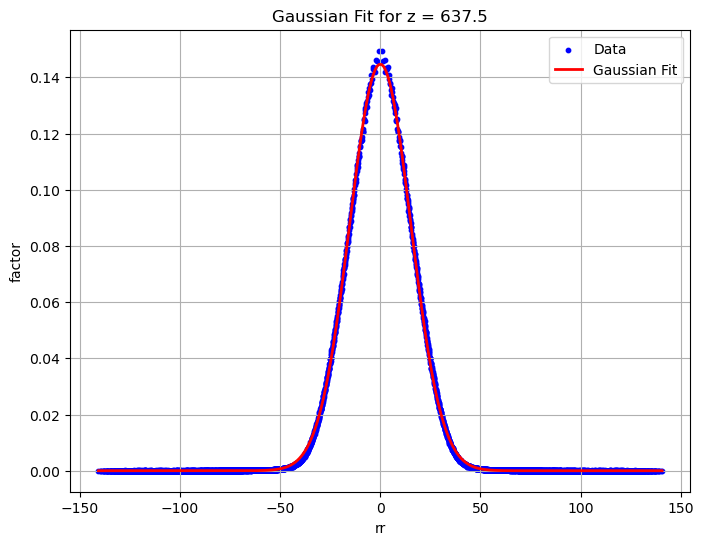

Fitted parameters: a=0.14353866478413524, x0=-6.173322699437299e-11, sigma=15.311853565980739


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


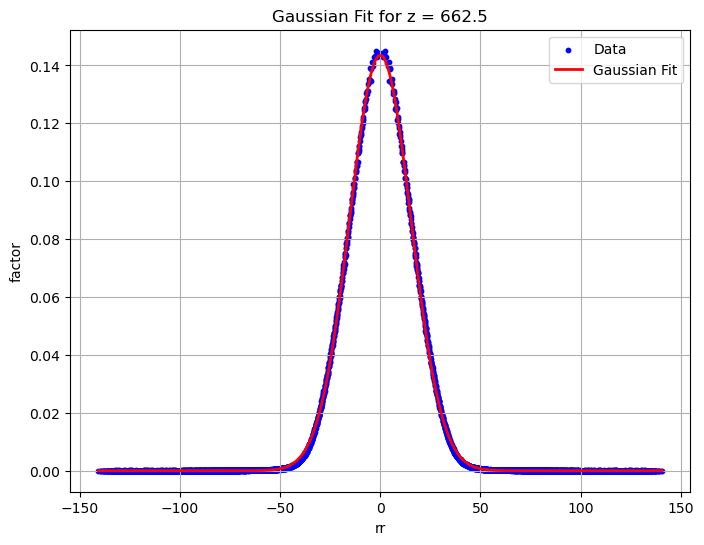

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.14185593617701367, x0=-2.642098345649778e-10, sigma=15.376282013645117


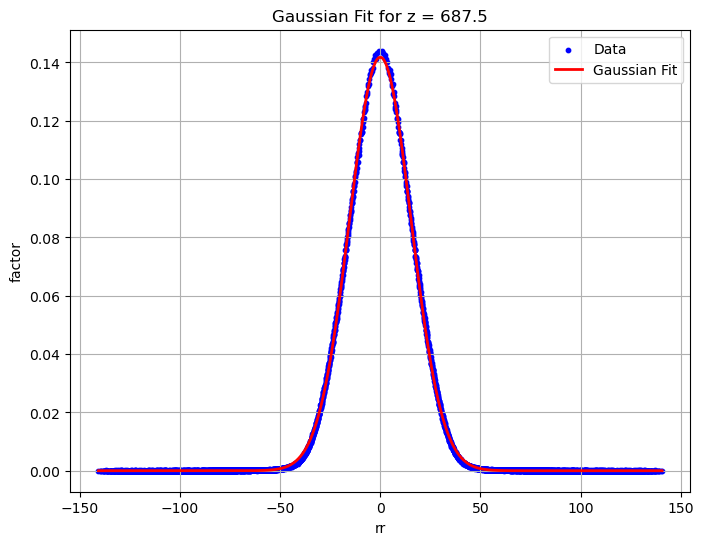

Fitted parameters: a=0.14024823194934316, x0=-3.9646409269178387e-10, sigma=15.438122031338013


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


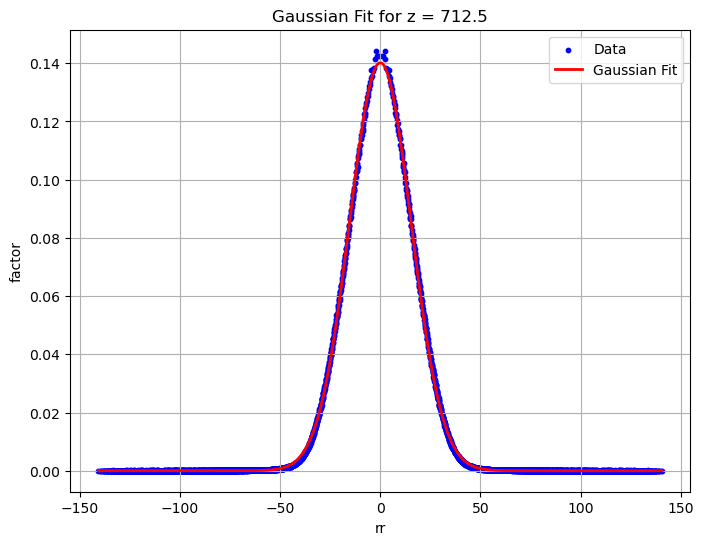

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.13890803772064717, x0=-7.364770807433723e-11, sigma=15.491161628122956


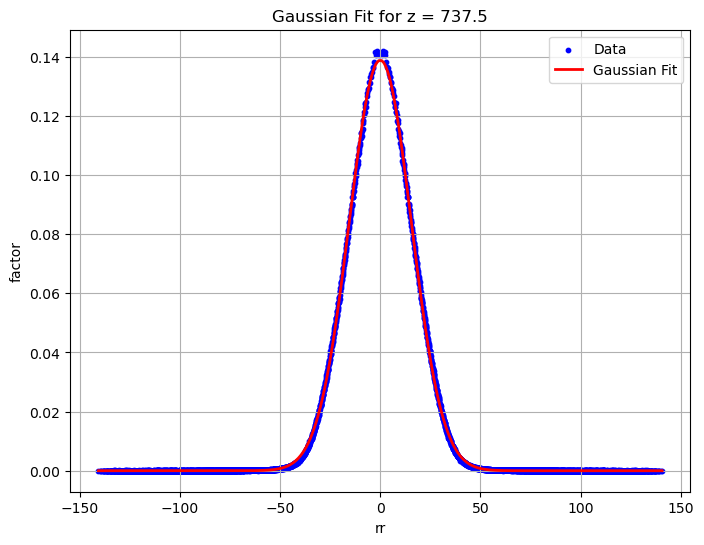

Fitted parameters: a=0.1377382252171612, x0=-6.315455897601203e-11, sigma=15.533741605342453


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


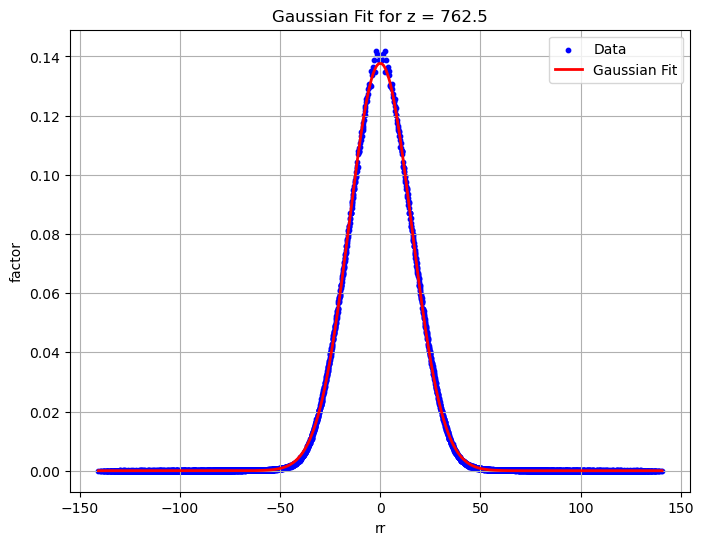

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.13701171115628316, x0=2.3735405435807567e-10, sigma=15.551660086000892


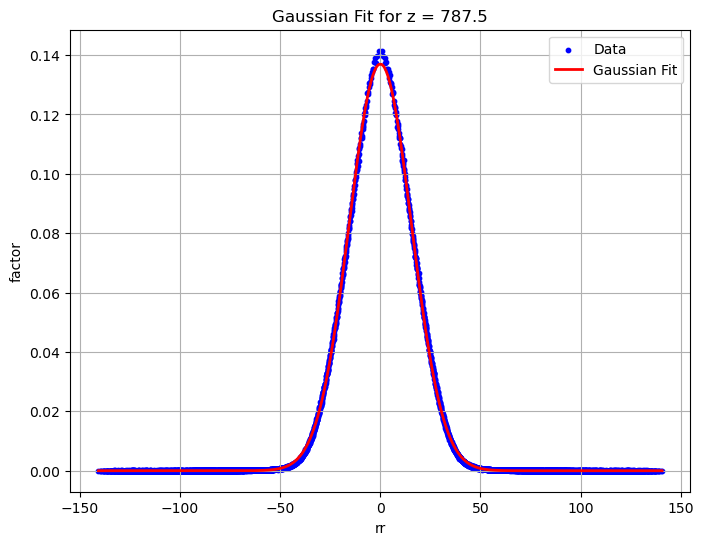

Fitted parameters: a=0.13583497475975453, x0=-5.260677418764027e-11, sigma=15.589850527823984


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


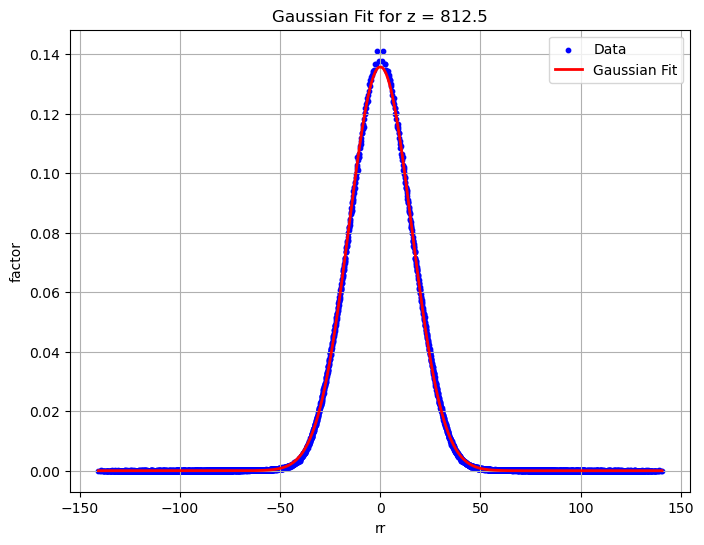

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.13458778763787463, x0=2.4319351185445775e-10, sigma=15.637857681037998


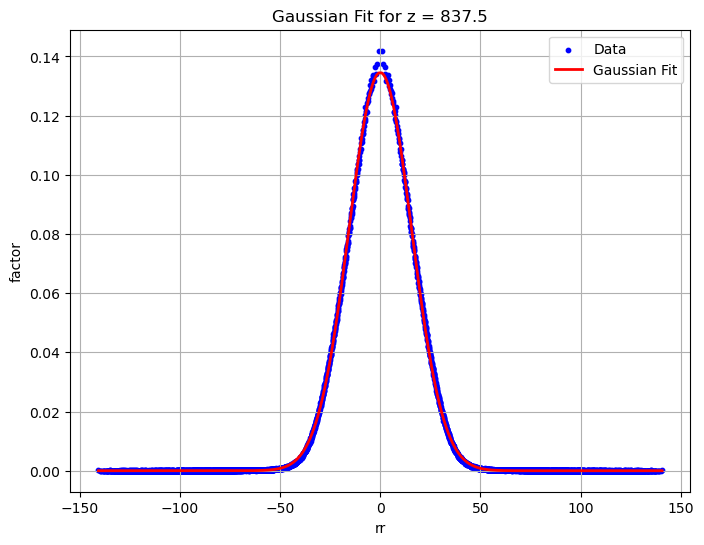

Fitted parameters: a=0.13378095123036146, x0=1.491262742902442e-11, sigma=15.659864987473727


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


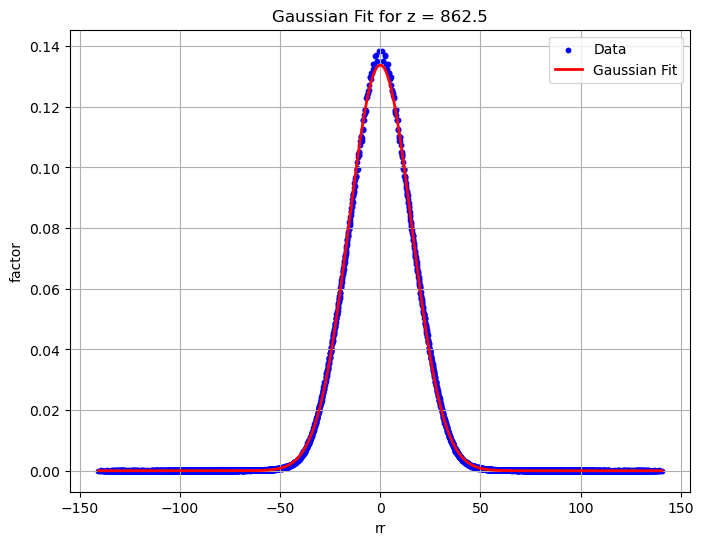

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.13239991088303713, x0=1.332410230093802e-10, sigma=15.716860677149898


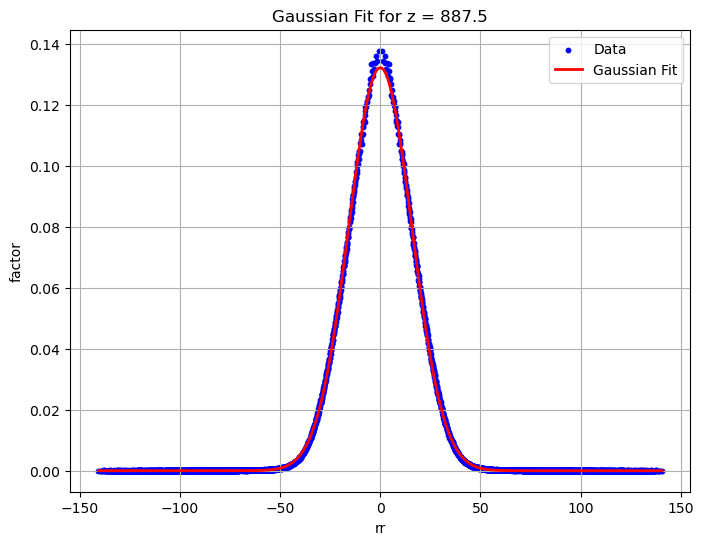

Fitted parameters: a=0.13200233629013558, x0=1.435081886949812e-10, sigma=15.710399420462688


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


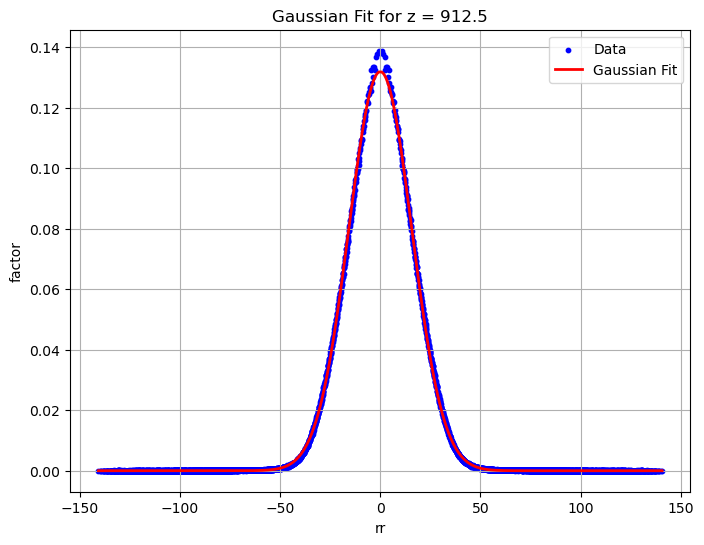

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.131449758943803, x0=5.637138943406341e-10, sigma=15.719626379806314


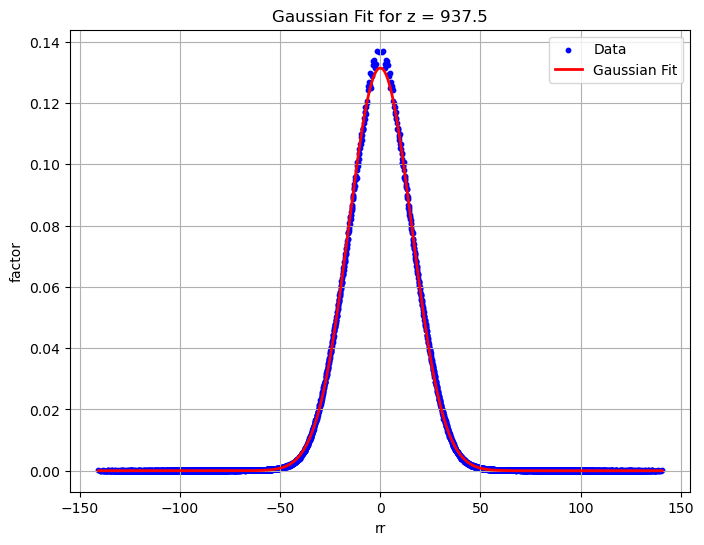

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.13035988665422957, x0=-4.806468674236909e-10, sigma=15.755490781698754


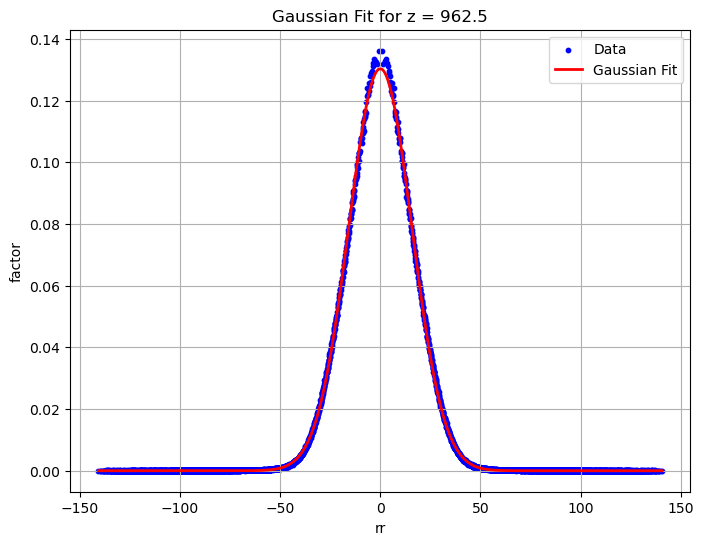

Fitted parameters: a=0.1298428826686951, x0=1.464525696556548e-10, sigma=15.76367032247918


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


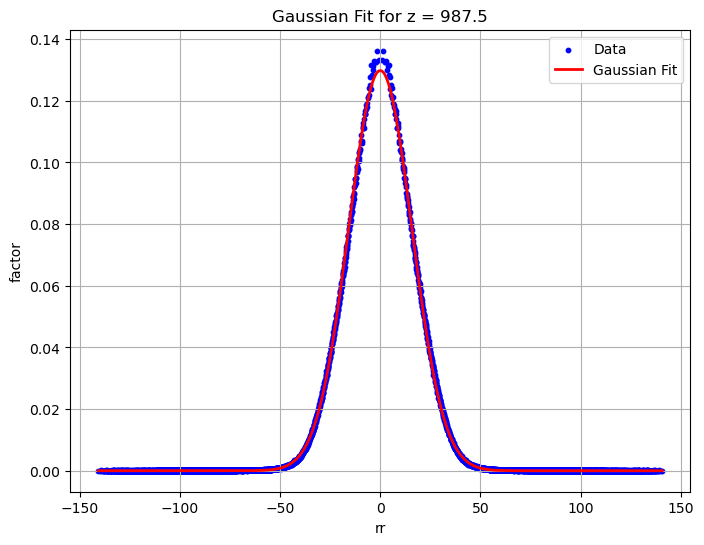

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.12932956992227368, x0=-6.805608017958481e-11, sigma=15.774602784666454


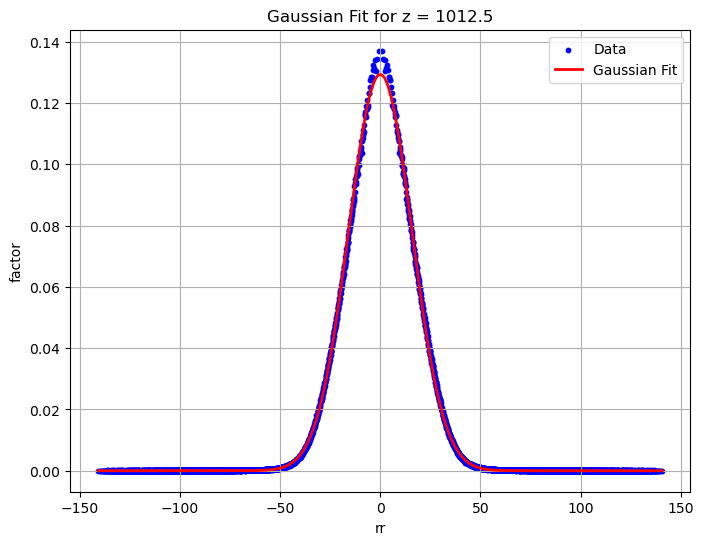

Fitted parameters: a=0.12864040424458706, x0=-1.7121200523649451e-10, sigma=15.784905580357174


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


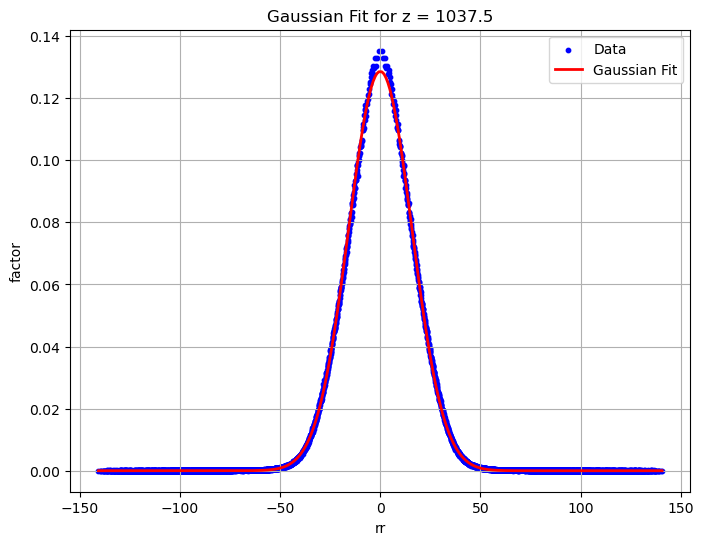

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.12854021858859413, x0=-1.796136094142363e-10, sigma=15.76671101660841


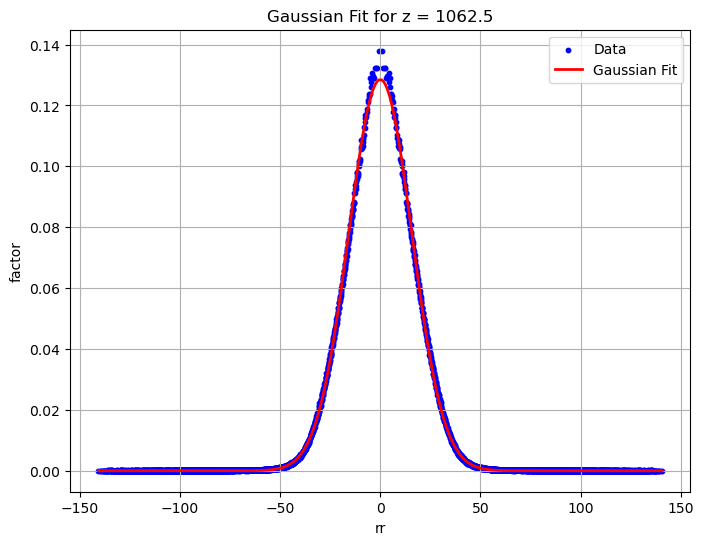

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.12798949071741175, x0=4.2603939138389827e-10, sigma=15.784119455873071


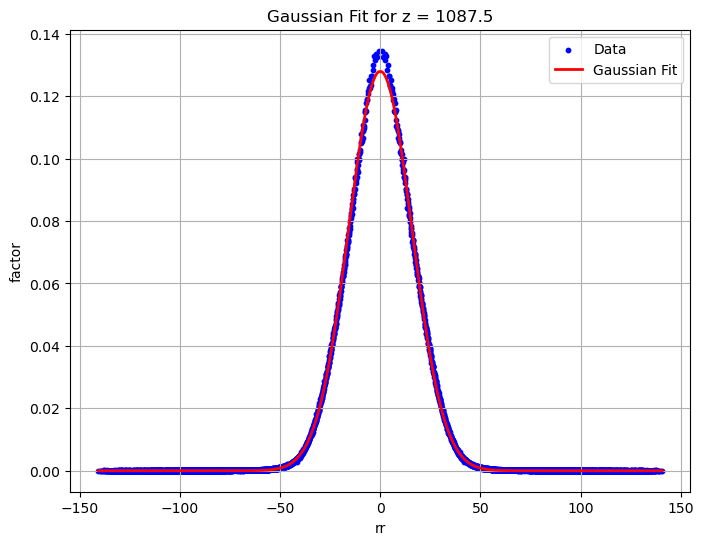

Fitted parameters: a=0.1269902494757523, x0=-1.7517736827210754e-10, sigma=15.819598373487494


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


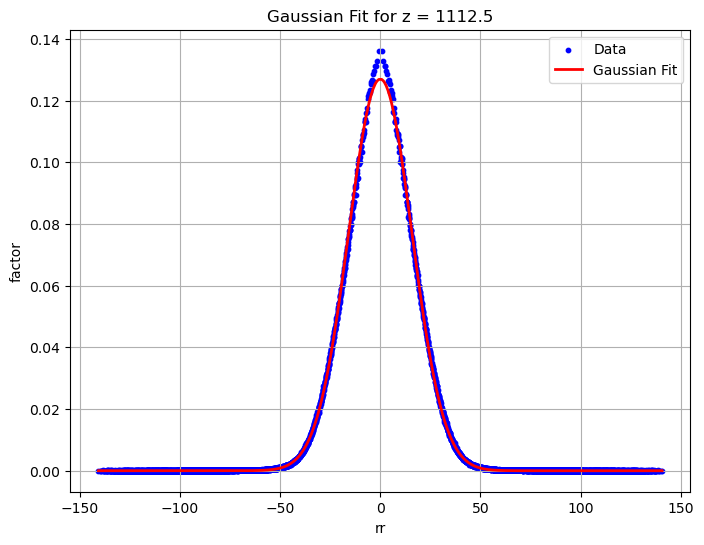

/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


Fitted parameters: a=0.12654299948943143, x0=1.213697418200467e-10, sigma=15.827991730158558


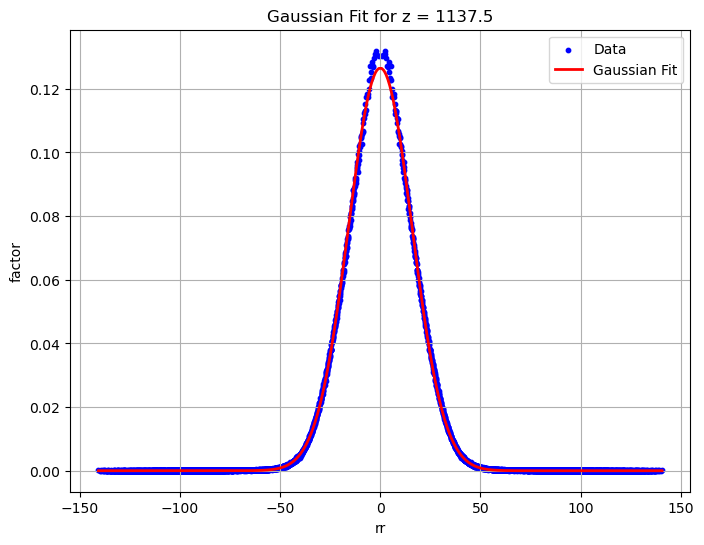

Fitted parameters: a=0.12611675731321026, x0=-1.0491816098194341e-05, sigma=15.820393972236843


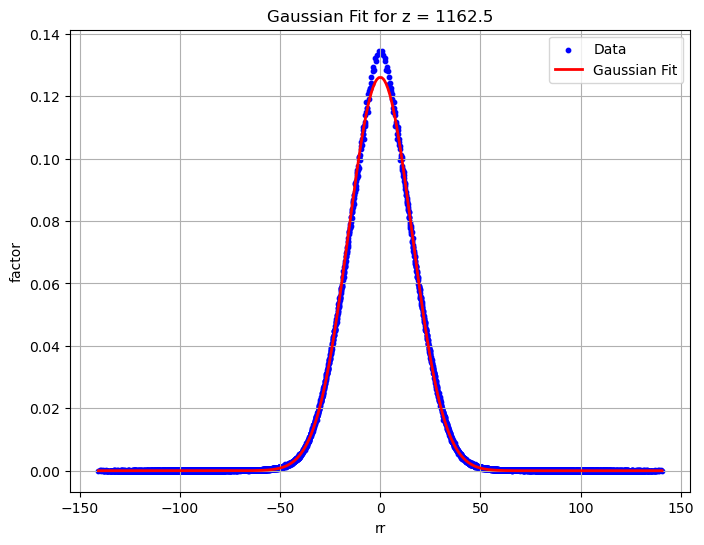

Fitted parameters: a=0.12613076416968957, x0=3.399877385058586e-11, sigma=15.807119819811602


/tmp/ipykernel_34123/3035542894.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])


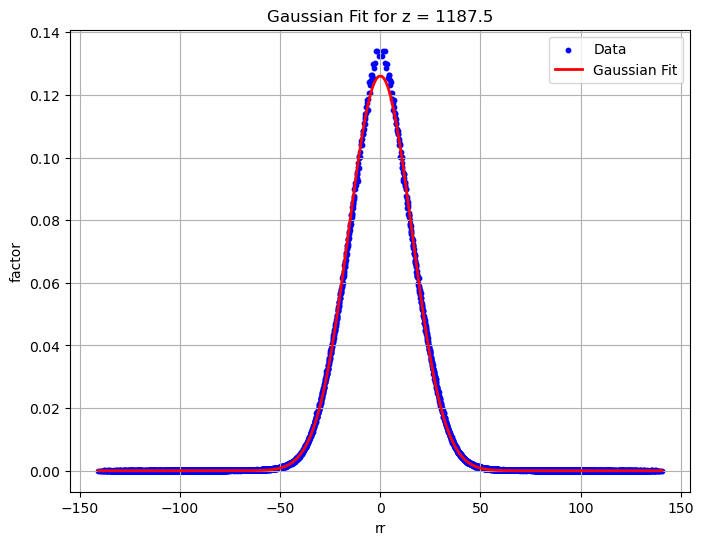

In [22]:
from scipy.optimize import curve_fit

sigma_list = {}

for z_val in psf_data_R15616.z.unique():
    data = func.z_specific_rr(psf_data_R15616, z_val)
    # symmetric around deltaR = 0
    y_data = np.concatenate([np.flip((data.factor.values)), (data.factor.values)])
    x_data = np.concatenate([np.flip((-data.rr.values)), (data.rr.values)])


    # Fit the Gaussian curve
    popt, pcov = curve_fit(gaussian, x_data, y_data, p0=[1, 0, 1])

    # Extract the fitted parameters
    a, x0, sigma = popt
    print(f"Fitted parameters: a={a}, x0={x0}, sigma={sigma}")
    # Plot the data and the Gaussian fit
    plt.figure(figsize=(8, 6))
    plt.scatter(x_data, y_data, label='Data', color='blue', s=10)
    plt.plot(x_data, gaussian(x_data, *popt), label='Gaussian Fit', color='red', linewidth=2)
    plt.xlabel('rr')
    plt.ylabel('factor')
    plt.title(f'Gaussian Fit for z = {z_val}')
    plt.legend()
    plt.grid()
    plt.show()

    sigma_list[z_val] = sigma

    

Linear fit coefficients: Slope = 0.10291517674396128, Intercept = 152.18738355676257


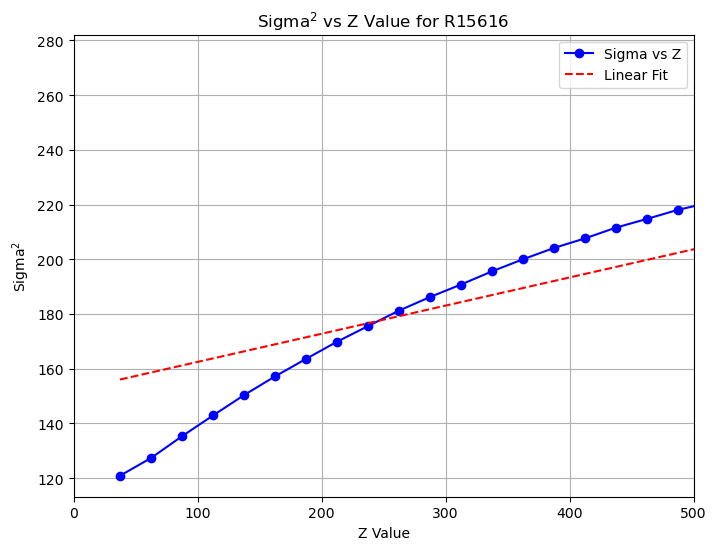

In [24]:
# Extract keys and values from sigma_list
z_values = (list(sigma_list.keys()))
sigma_values = np.square(list(sigma_list.values()))

# exclude the first point
z_values = z_values[1:]
sigma_values = sigma_values[1:]

# Fit a linear trend to the data
coefficients = np.polyfit(z_values, sigma_values, 1)
linear_fit = np.poly1d(coefficients)

# Print the coefficients
print(f"Linear fit coefficients: Slope = {coefficients[0]}, Intercept = {coefficients[1]}")

# Plot the data
plt.figure(figsize=(8, 6))

plt.plot(z_values, sigma_values, marker='o', linestyle='-', color='b', label='Sigma vs Z')
plt.plot(z_values, linear_fit(z_values), linestyle='--', color='r', label='Linear Fit')
plt.xlabel('Z Value')
plt.ylabel('Sigma$^2$')
plt.title('Sigma$^2$ vs Z Value for R15616')
plt.grid()
plt.xlim([0, 500])
plt.legend()
plt.show()